In [1]:
from sklearn import decomposition
from tqdm import tqdm
import gc
from matplotlib import pyplot as plt
import seaborn as sns
import math
import scipy as sc
from random import randint, sample

from numba import jit

from scipy.stats import ks_2samp as ks2
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import kruskal
from scipy.stats import wasserstein_distance as w1_dist
from scipy.stats import energy_distance as w2_dist
from scipy.stats import anderson_ksamp as anderson # test if samples are from the same distribution

from sklearn.linear_model import LogisticRegressionCV as LR
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

%reload_ext autoreload
%autoreload 2
#%load_ext autoreload

import numpy as np
import pandas as pd
import scipy as sc

from tqdm import tqdm

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectFdr
from sklearn.feature_selection import SelectFpr

In [2]:
Meta_Methyl = pd.read_csv("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/HumanMethylation450_meta.csv", sep=",", skiprows=7)
Meta_Methyl = Meta_Methyl[['IlmnID', 'Name', 'CHR', 'UCSC_RefGene_Name', 'UCSC_RefGene_Accession', 'UCSC_RefGene_Group', 'Regulatory_Feature_Group']]

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (2,4,11,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
Methylation_scores = pd.read_csv("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_results/Methylation_all_res.csv", sep=";")
RNA_scores = pd.read_csv("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_results/RNA_separation_scores.csv", sep=";")

RNA_scores.set_index("Unnamed: 0", inplace=True)
Methylation_scores.set_index("Unnamed: 0", inplace=True)
Methylation_scores['LR_coeff_standard']=(Methylation_scores.LR_coeff_abs - Methylation_scores.LR_coeff_abs.mean())/Methylation_scores.LR_coeff_abs.std()

In [4]:
# add suffixes
RNA_scores.columns = [_col+"_RNA" for _col in RNA_scores.columns]
Methylation_scores.columns = [_col+"_Methylation" for _col in Methylation_scores.columns]

In [5]:
Merged = RNA_scores.copy().merge(Methylation_scores, how='left', left_on='Gene_RNA', right_on='Gene_Methylation')
Merged['score_WASS1_RNA_standard']=(Merged.score_WASS1_RNA - Merged.score_WASS1_RNA.mean())/Merged.score_WASS1_RNA.std()
Merged['score_WASS1_Methylation_standard']=(Merged.score_WASS1_Methylation - Merged.score_WASS1_Methylation.mean())/Merged.score_WASS1_Methylation.std()

In [6]:
Merged['WASS1_combined'] = Merged.score_WASS1_RNA * Merged.score_WASS1_Methylation
Merged['WASS2_combined'] = Merged.score_WASS2_RNA * Merged.score_WASS2_Methylation

In [7]:
Merged.columns

Index(['pvals_KW_RNA', 'score_KW_RNA', 'pvals_FDR_RNA', 'score_FDR_RNA',
       'pvals_KS_RNA', 'score_KS_RNA', 'pvals_MWU_RNA', 'score_MWU_RNA',
       'score_WASS1_RNA', 'score_WASS2_RNA', 'Gender_RNA', 'Chr_RNA',
       'Gene_RNA', 'Start_RNA', 'Stop_RNA', 'Strand_RNA', 'fc_split_RNA',
       'fold_change_abs_RNA', 'fold_change_rel_RNA', 'fold_change_median_RNA',
       'LR_coeff_normalised_RNA', 'LDA_score_normalised_RNA',
       'LR_coeff_abs_Methylation', 'LR_coeff_sign_Methylation',
       'pvals_FDR_Methylation', 'score_FDR_Methylation',
       'pvals_KS_Methylation', 'score_KS_Methylation', 'pvals_MWU_Methylation',
       'score_MWU_Methylation', 'score_WASS1_Methylation',
       'score_WASS2_Methylation', 'abs_fc_Methylation', 'rel_fc_Methylation',
       'abs_fc_median_Methylation', 'split_fc_Methylation', 'Chr_Methylation',
       'Start_Methylation', 'Stop_Methylation', 'Strand_Methylation',
       'Gene_Methylation', 'Relation_CpG_Island_Methylation',
       'LR_coeff_sta

In [8]:
Merged['WASS1_prod'] = Merged['score_WASS1_RNA_standard']*Merged['score_WASS1_Methylation_standard']

Text(0, 0.5, 'Median RNA expression change')

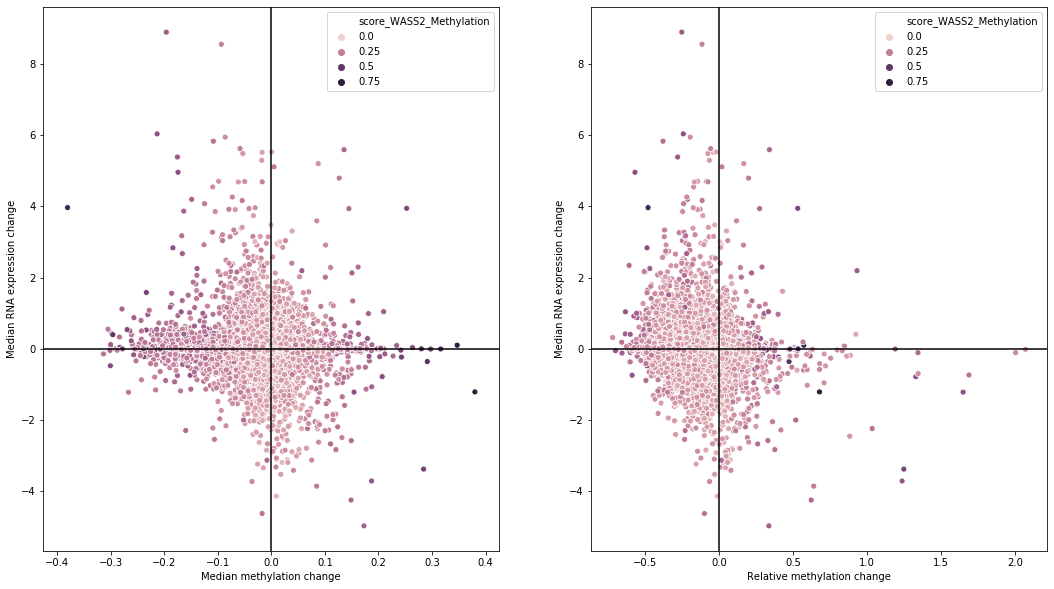

In [9]:
fig, ax = plt.subplots(figsize=(18,10), ncols=2)
agg=Merged[['Gene_RNA', 'fold_change_median_RNA', 'abs_fc_median_Methylation', 'rel_fc_Methylation', 'WASS1_prod',
            'score_FDR_RNA', 'score_KS_RNA', 'score_WASS2_Methylation', 'score_FDR_Methylation']].groupby(by='Gene_RNA').mean()
sns.scatterplot(data=agg, x='abs_fc_median_Methylation', y='fold_change_median_RNA', alpha=1, hue='score_WASS2_Methylation', ax=ax[0])
ax[0].axvline(0, color='black')
ax[0].axhline(0, color='black')
ax[0].set_xlabel('Median methylation change')
ax[0].set_ylabel('Median RNA expression change')

sns.scatterplot(data=agg, x='rel_fc_Methylation', y='fold_change_median_RNA', alpha=1, hue='score_WASS2_Methylation', ax=ax[1])
ax[1].axvline(0, color='black')
ax[1].axhline(0, color='black')
ax[1].set_xlabel('Relative methylation change')
ax[1].set_ylabel('Median RNA expression change')

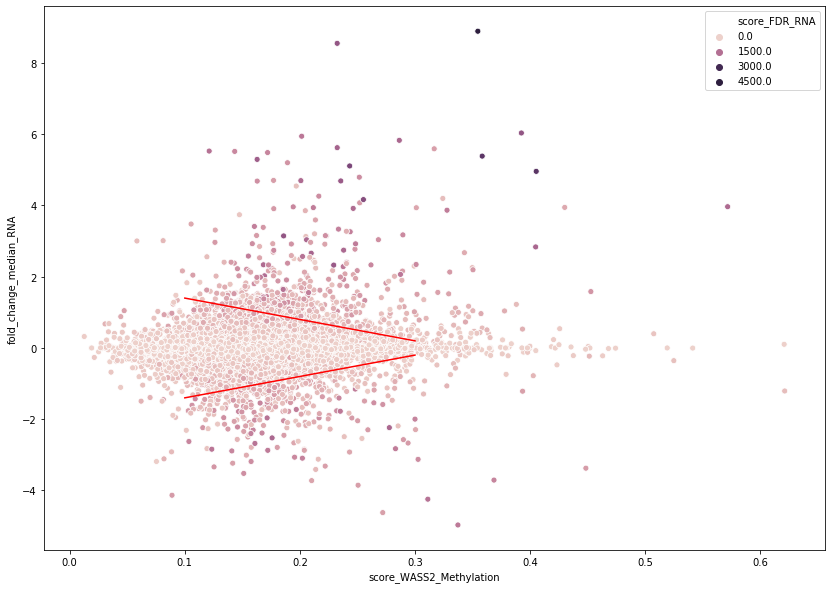

In [10]:
fig, ax = plt.subplots(figsize=(14,10))
agg=Merged[['Gene_RNA', 'fold_change_median_RNA', 'abs_fc_median_Methylation', 'WASS1_prod', 'score_FDR_RNA', 'fold_change_rel_RNA',
            'score_KS_RNA', 'score_KS_Methylation', 'score_WASS1_RNA', 'score_WASS2_Methylation']].groupby(by='Gene_RNA').mean()
sns.scatterplot(data=agg, x='score_WASS2_Methylation', y='fold_change_median_RNA', alpha=1, hue='score_FDR_RNA')
xd = np.linspace(0.1,0.3,20)
yd = 6*xd-2
plt.plot(xd, yd, '-r')

xd = np.linspace(0.1,0.3,20)
yd = -6*xd+2
plt.plot(xd, yd, '-r')

In [11]:
Merged['change_coeff_median'] = Merged.fold_change_median_RNA/(Merged.abs_fc_median_Methylation+0.01)
Merged['change_coeff_mean'] = Merged.fold_change_abs_RNA/(Merged.abs_fc_Methylation+0.01)

Text(0.5, 0, 'Delta RNA expression / Delta Methylation')

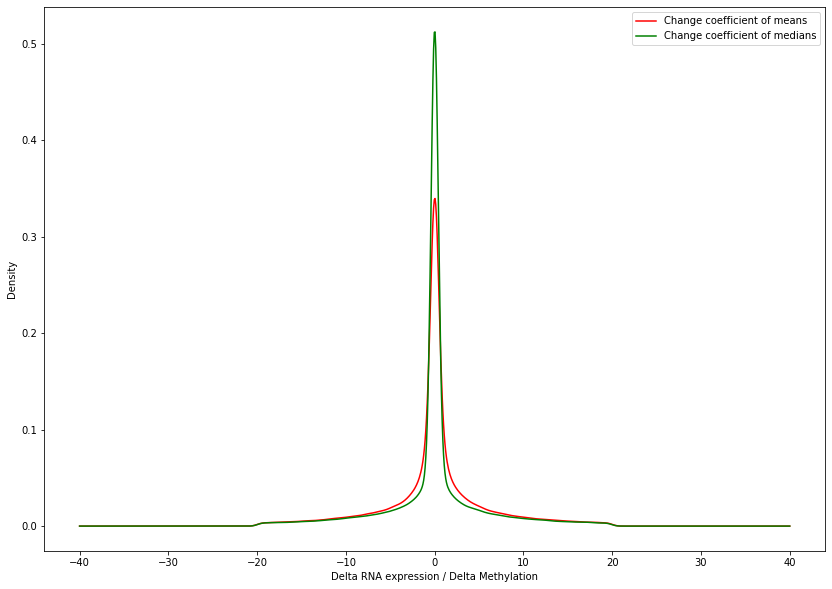

In [12]:
Merged.query('change_coeff_mean>-20').query('change_coeff_mean<20')['change_coeff_mean'].plot.kde(color='red', label='Change coefficient of means', figsize=(14,10))
Merged.query('change_coeff_median>-20').query('change_coeff_median<20')['change_coeff_median'].plot.kde(color='green', label='Change coefficient of medians')
plt.legend()
plt.xlabel('Delta RNA expression / Delta Methylation')

In [13]:
Merged.columns

Index(['pvals_KW_RNA', 'score_KW_RNA', 'pvals_FDR_RNA', 'score_FDR_RNA',
       'pvals_KS_RNA', 'score_KS_RNA', 'pvals_MWU_RNA', 'score_MWU_RNA',
       'score_WASS1_RNA', 'score_WASS2_RNA', 'Gender_RNA', 'Chr_RNA',
       'Gene_RNA', 'Start_RNA', 'Stop_RNA', 'Strand_RNA', 'fc_split_RNA',
       'fold_change_abs_RNA', 'fold_change_rel_RNA', 'fold_change_median_RNA',
       'LR_coeff_normalised_RNA', 'LDA_score_normalised_RNA',
       'LR_coeff_abs_Methylation', 'LR_coeff_sign_Methylation',
       'pvals_FDR_Methylation', 'score_FDR_Methylation',
       'pvals_KS_Methylation', 'score_KS_Methylation', 'pvals_MWU_Methylation',
       'score_MWU_Methylation', 'score_WASS1_Methylation',
       'score_WASS2_Methylation', 'abs_fc_Methylation', 'rel_fc_Methylation',
       'abs_fc_median_Methylation', 'split_fc_Methylation', 'Chr_Methylation',
       'Start_Methylation', 'Stop_Methylation', 'Strand_Methylation',
       'Gene_Methylation', 'Relation_CpG_Island_Methylation',
       'LR_coeff_sta

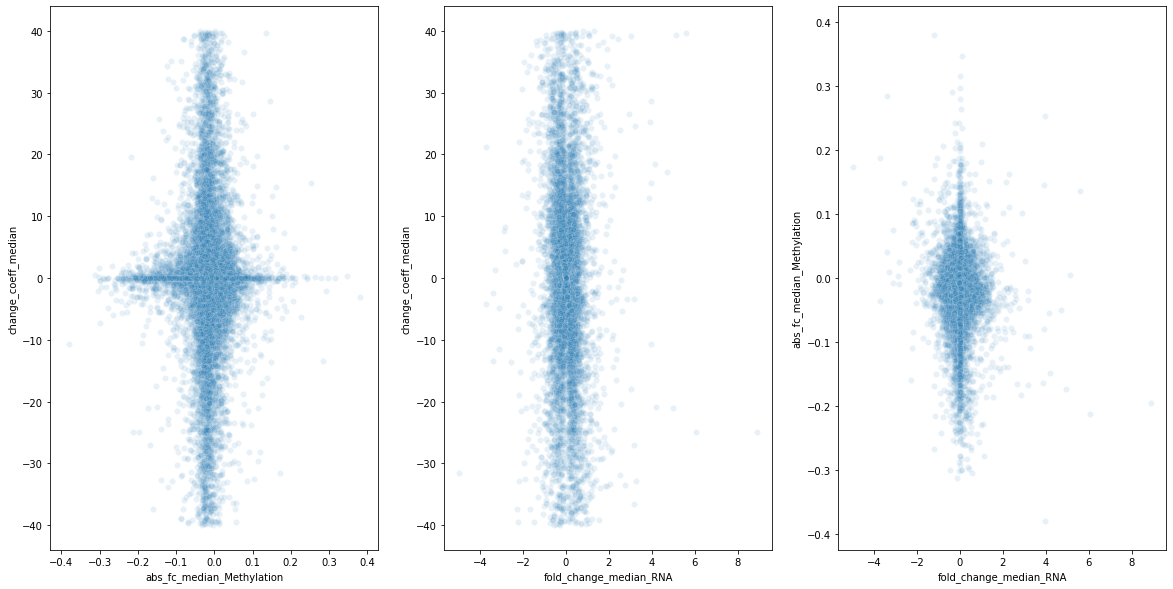

In [31]:
fig, ax = plt.subplots(figsize=(20,10), ncols=3)
agg = Merged[['Gene_RNA', 'change_coeff_median', 'abs_fc_median_Methylation', 
              'fold_change_median_RNA', 'fc_split_RNA', 'split_fc_Methylation']].groupby('Gene_RNA').mean().reset_index()
sns.scatterplot(data=agg.query('change_coeff_median<40').query('change_coeff_median>-40'), 
                y='change_coeff_median', x='abs_fc_median_Methylation', alpha=0.1, ax=ax[0]) # fc_rel_methylation abs_fc_median_Methylation

sns.scatterplot(data=agg.query('change_coeff_median<40').query('change_coeff_median>-40'), 
                y='change_coeff_median', x='fold_change_median_RNA', alpha=0.1, ax=ax[1]) # fc_rel_methylation abs_fc_median_Methylation

sns.scatterplot(data=agg.query('change_coeff_median<40').query('change_coeff_median>-40'), 
                y='abs_fc_median_Methylation', x='fold_change_median_RNA', alpha=0.1, ax=ax[2]) # fc_rel_methylation abs_fc_median_Methylation
#ax[1].set_xlim(-4,4)

We see clearly that the absolute rate of change is inversely proportional to the fold change of the methylation.

The relation between methylation and RNA expression is not clearly expressed in the current data. We would expect that the methylation change is negatively correlated with the change in RNA expression but both the negative and positive correlation occur equally for relative methylation fold changes above $0.1$.

It seems that the methylation only correlates significantly with a small number of gene expressions but in the bulk a **higher** methylation change corresponds
to a **smaller** absolute expression change. An easy explanation might be that higher methylation changes are associated with lower initial values of the RNA expression. 

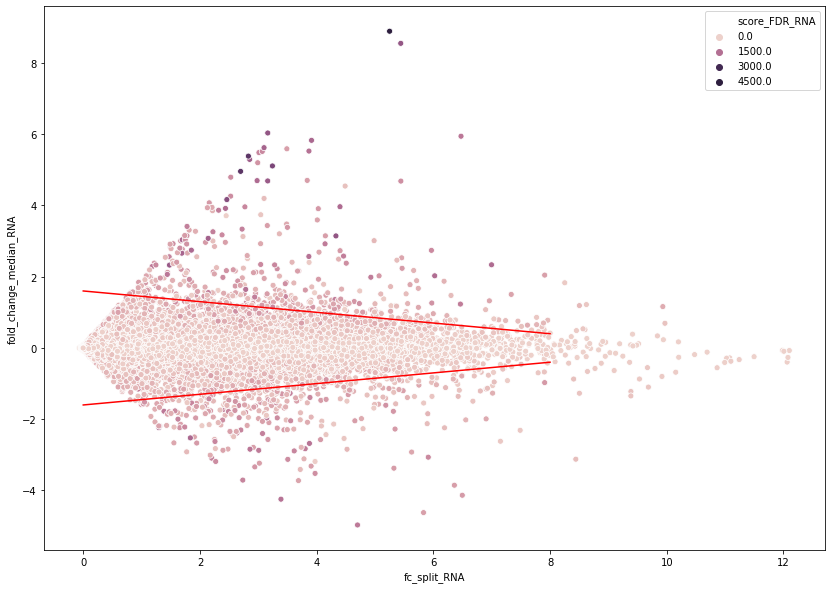

In [12]:
fig, ax = plt.subplots(figsize=(14,10))
agg=Merged[['Gene_RNA', 'fc_split_RNA', 'fold_change_median_RNA', 'abs_fc_median_Methylation', 'WASS1_prod', 'score_FDR_RNA', 'fold_change_rel_RNA',
            'score_KS_RNA', 'score_KS_Methylation', 'score_WASS1_RNA', 'score_WASS1_Methylation']].groupby(by='Gene_RNA').mean()
sns.scatterplot(data=agg.query('fold_change_rel_RNA<2500').query('fold_change_rel_RNA>-100'),
                y='fold_change_median_RNA', x='fc_split_RNA', alpha=1, hue='score_FDR_RNA')

xd = np.linspace(0,8,20)
yd = 0.15*xd-1.6
plt.plot(xd, yd, '-r')

xd = np.linspace(0,8,20)
yd = -0.15*xd+1.6
plt.plot(xd, yd, '-r')

In [13]:
Methylation_scores.columns

Index(['LR_coeff_abs_Methylation', 'LR_coeff_sign_Methylation',
       'pvals_FDR_Methylation', 'score_FDR_Methylation',
       'pvals_KS_Methylation', 'score_KS_Methylation', 'pvals_MWU_Methylation',
       'score_MWU_Methylation', 'score_WASS1_Methylation',
       'score_WASS2_Methylation', 'abs_fc_Methylation', 'rel_fc_Methylation',
       'abs_fc_median_Methylation', 'split_fc_Methylation', 'Chr_Methylation',
       'Start_Methylation', 'Stop_Methylation', 'Strand_Methylation',
       'Gene_Methylation', 'Relation_CpG_Island_Methylation',
       'LR_coeff_standard_Methylation'],
      dtype='object')

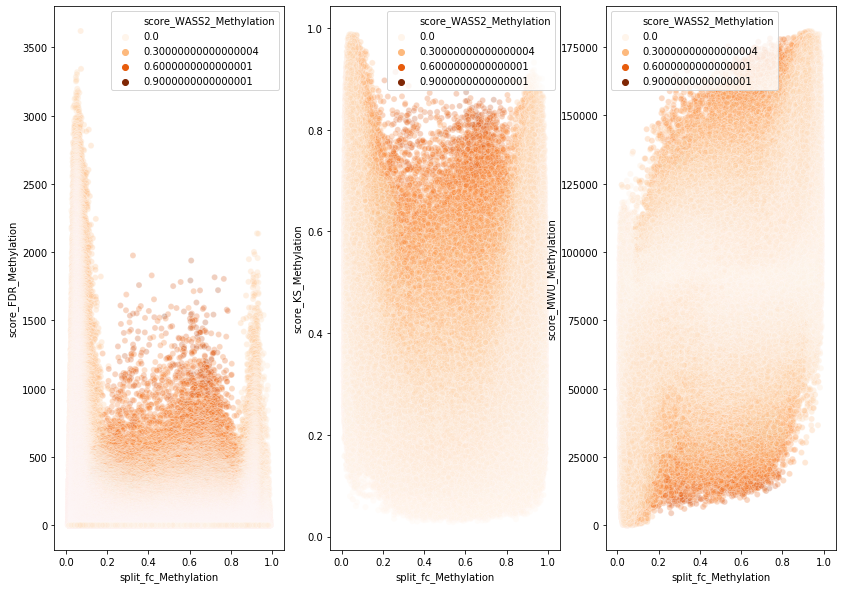

In [14]:
fig, ax = plt.subplots(figsize=(14,10), ncols=3)
sns.scatterplot(data=Methylation_scores, x='split_fc_Methylation', y='score_FDR_Methylation', alpha=0.25, hue='score_WASS2_Methylation', 
                palette='Oranges', ax=ax[0])
sns.scatterplot(data=Methylation_scores, x='split_fc_Methylation', y='score_KS_Methylation', alpha=0.25, hue='score_WASS2_Methylation', 
                palette='Oranges', ax=ax[1])
sns.scatterplot(data=Methylation_scores, x='split_fc_Methylation', y='score_MWU_Methylation', alpha=0.25, hue='score_WASS2_Methylation', 
                palette='Oranges', ax=ax[2])
plt.savefig("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_results/split_v_scores.jpg")

In [15]:
Methylation_scores['LR_abs_minmax'] = Methylation_scores.LR_coeff_abs_Methylation/Methylation_scores.LR_coeff_abs_Methylation.max()

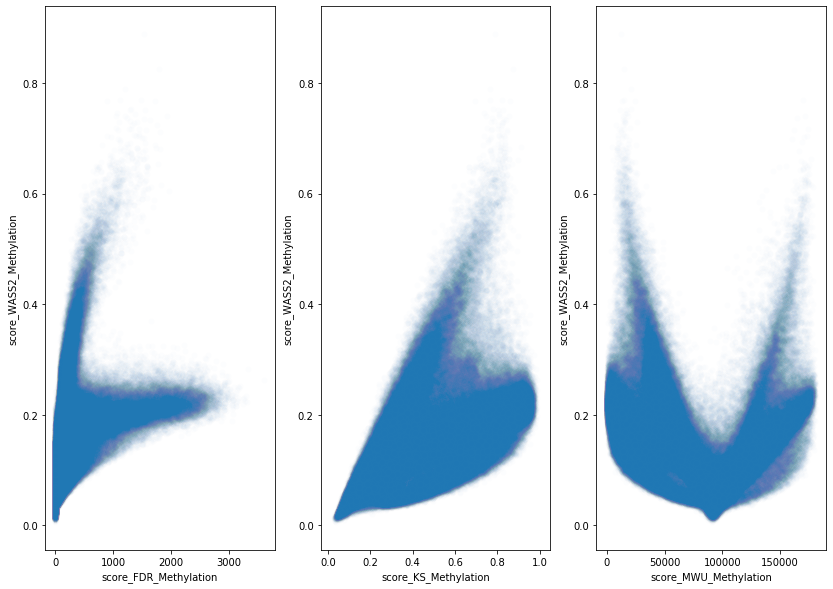

In [16]:
fig, ax = plt.subplots(figsize=(14,10), ncols=3)
sns.scatterplot(data=Methylation_scores, x='score_FDR_Methylation', y='score_WASS2_Methylation', alpha=0.01, ax=ax[0])
sns.scatterplot(data=Methylation_scores, x='score_KS_Methylation', y='score_WASS2_Methylation', alpha=0.01, ax=ax[1])
sns.scatterplot(data=Methylation_scores, x='score_MWU_Methylation', y='score_WASS2_Methylation', alpha=0.01, ax=ax[2])
plt.savefig("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_results/scores_v_WASS2.jpg")

What the above tells us is dat relying on the seperation scores *alone* may give a skewed picture. The seperability 
as evaluated by KS/MWU is based on the *cleanliness* with which the distributions can be seperated, not on *how far* they are separated. 
In principle we can have medians that are quite far from eachother but which have overlapping tails/head which may give
it lower separation scores than say 2 distributions that both a low methylation/expression median but which can be separated more cleanly.

I.e. something like the measurement resolution (of expression values or methylation values) or a higher importance of larger methylation/expression differences
is not *directly* incorporated in these tests, hence these need to be incorporated through other metrics such as the Wasserstein distances or the absolute fold changes with respect to the fold split.

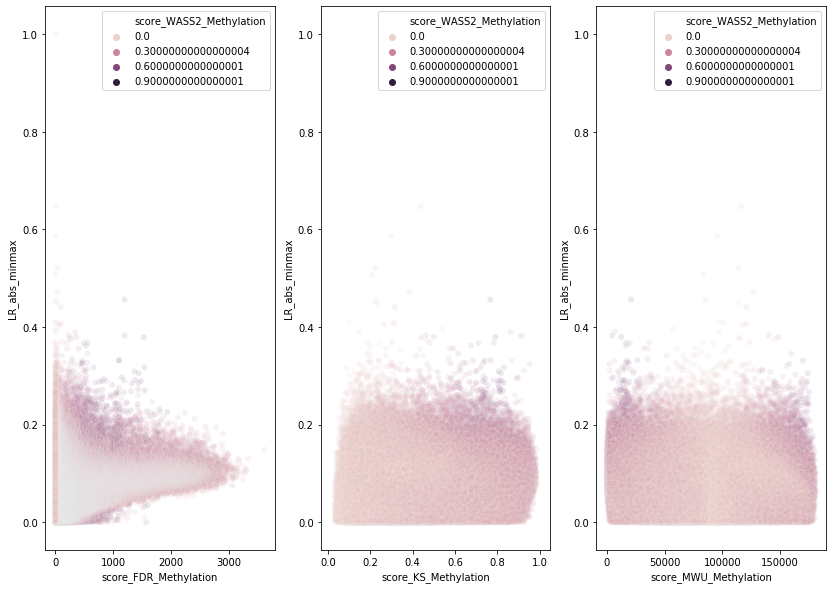

In [17]:
fig, ax = plt.subplots(figsize=(14,10), ncols=3)
sns.scatterplot(data=Methylation_scores, x='score_FDR_Methylation', y='LR_abs_minmax', alpha=0.1, 
                hue='score_WASS2_Methylation', ax=ax[0])
sns.scatterplot(data=Methylation_scores, x='score_KS_Methylation', y='LR_abs_minmax', alpha=0.1, 
                hue='score_WASS2_Methylation', ax=ax[1])
sns.scatterplot(data=Methylation_scores, x='score_MWU_Methylation', y='LR_abs_minmax', alpha=0.1, 
                hue='score_WASS2_Methylation', ax=ax[2])

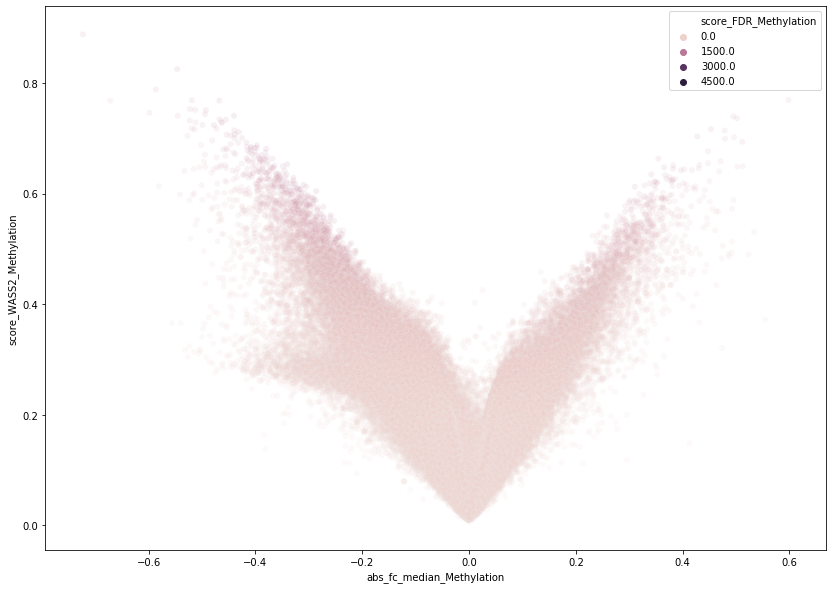

In [18]:
fig, ax = plt.subplots(figsize=(14,10))
sns.scatterplot(data=Methylation_scores, x='abs_fc_median_Methylation', y='score_WASS2_Methylation', alpha=0.1, 
                hue='score_FDR_Methylation')

In [32]:
# make one score, include (Wass2, FDR score, fc split, fc median)
# Score one : Wass 1 x KS
# Score two : Wass 2 x KS
# Score three : fc_median x KS

Methylation_scores['SupScore1'] = np.sign(Methylation_scores.abs_fc_median_Methylation) * Methylation_scores.score_WASS1_Methylation * Methylation_scores.score_KS_Methylation
Methylation_scores['SupScore2'] = np.sign(Methylation_scores.abs_fc_median_Methylation) * Methylation_scores.score_WASS2_Methylation * Methylation_scores.score_KS_Methylation
Methylation_scores['SupScore3'] = Methylation_scores.abs_fc_median_Methylation * Methylation_scores.score_KS_Methylation

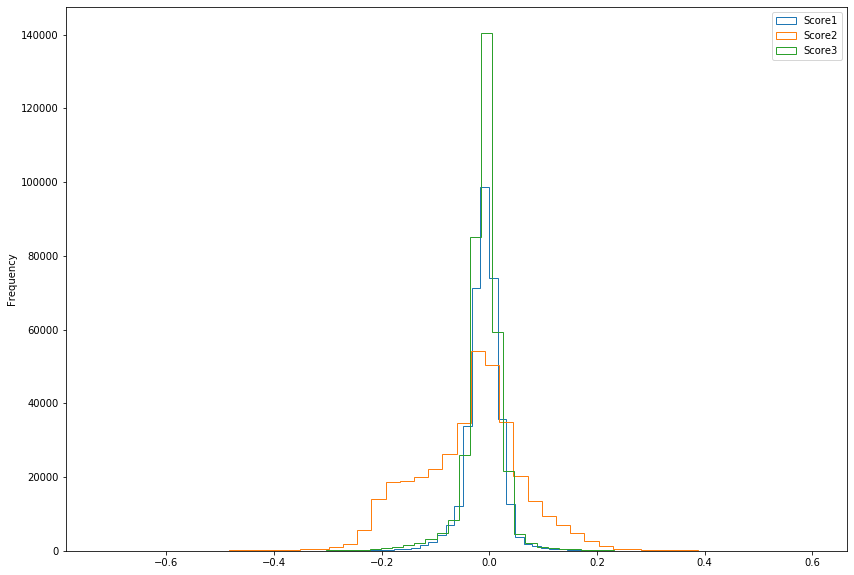

In [33]:
Methylation_scores['SupScore1'].plot.hist(bins=50, histtype='step', label='Score1', figsize=(14,10))
Methylation_scores['SupScore2'].plot.hist(bins=50, histtype='step', label='Score2')
Methylation_scores['SupScore3'].plot.hist(bins=50, histtype='step', label='Score3')
plt.legend()

In [34]:
Methylation_scores['SupScore1Abs'] = Methylation_scores.SupScore1.abs()
Methylation_scores['SupScore2Abs'] = Methylation_scores.SupScore2.abs()
Methylation_scores['SupScore3Abs'] = Methylation_scores.SupScore3.abs()

In [35]:
RNA_scores['SupScore1'] = np.sign(RNA_scores.fold_change_median_RNA) * RNA_scores.score_WASS1_RNA * RNA_scores.score_KS_RNA
RNA_scores['SupScore2'] = np.sign(RNA_scores.fold_change_median_RNA) * RNA_scores.score_WASS2_RNA * RNA_scores.score_KS_RNA
RNA_scores['SupScore3'] = RNA_scores.fold_change_median_RNA * RNA_scores.score_KS_RNA
RNA_scores['SupScore1Abs'] = RNA_scores.SupScore1.abs()
RNA_scores['SupScore2Abs'] = RNA_scores.SupScore2.abs()
RNA_scores['SupScore3Abs'] = RNA_scores.SupScore3.abs()

In [56]:
N = 200
top_N_overlap_meth = set(Methylation_scores.sort_values(by='SupScore1Abs', ascending=False).Gene_Methylation[:N].tolist()+
Methylation_scores.sort_values(by='SupScore2Abs', ascending=False).Gene_Methylation[:N].tolist()+
Methylation_scores.sort_values(by='SupScore3Abs', ascending=False).Gene_Methylation[:N].tolist())

top_N_overlap_rna = set(RNA_scores.sort_values(by='SupScore1Abs', ascending=False).Gene_RNA[:N].tolist()+
RNA_scores.sort_values(by='SupScore2Abs', ascending=False).Gene_RNA[:N].tolist()+
RNA_scores.sort_values(by='SupScore3Abs', ascending=False).Gene_RNA[:N].tolist())

overlap_ind = top_N_overlap_rna.intersection(top_N_overlap_meth)
print("In the top {} for 3 scores, we have \n\t {} unique genes for Methylation.\n\t {} unique genes for RNA.\n\t {} overlapping genes.".format(
        N, len(top_N_overlap_meth), len(top_N_overlap_rna), len(overlap_ind)))

In the top 200 for 3 scores, we have 
	 220 unique genes for Methylation.
	 242 unique genes for RNA.
	 9 overlapping genes.


100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


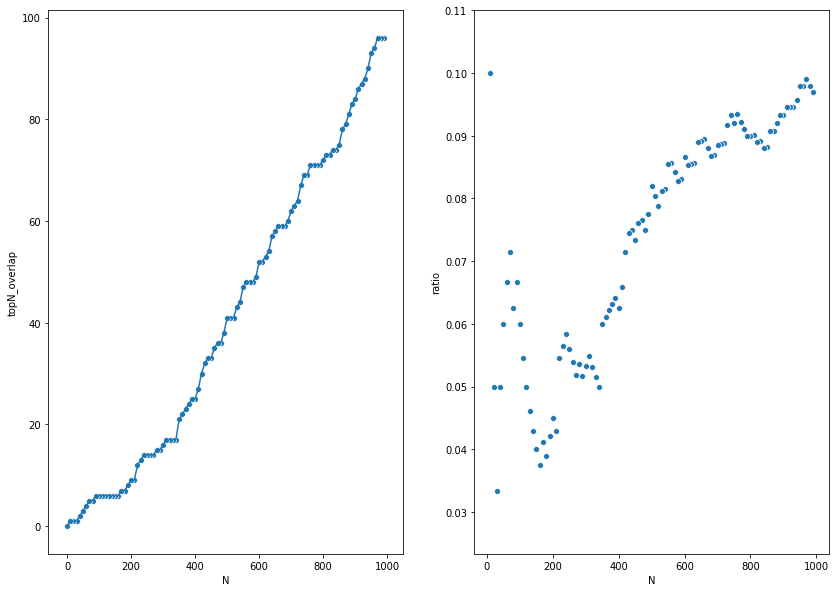

In [54]:
def overlap_counter(Nmax=10000, steps=20):
    Nstep = int(np.floor(Nmax/steps))
    counter_list = []
    for k in tqdm(range(0, steps)):
        N=Nmax-(1+k)*Nstep
        top_N_overlap_meth = set(Methylation_scores.sort_values(by='SupScore1Abs', ascending=False).Gene_Methylation[:N].tolist()+
        Methylation_scores.sort_values(by='SupScore2Abs', ascending=False).Gene_Methylation[:N].tolist()+
        Methylation_scores.sort_values(by='SupScore3Abs', ascending=False).Gene_Methylation[:N].tolist())

        top_N_overlap_rna = set(RNA_scores.sort_values(by='SupScore1Abs', ascending=False).Gene_RNA[:N].tolist()+
        RNA_scores.sort_values(by='SupScore2Abs', ascending=False).Gene_RNA[:N].tolist()+
        RNA_scores.sort_values(by='SupScore3Abs', ascending=False).Gene_RNA[:N].tolist())
        
        overlap_ind = top_N_overlap_rna.intersection(top_N_overlap_meth)
        
        counter_list.append({'N': N, 'topN_meth': len(top_N_overlap_meth), 'topN_rna': len(top_N_overlap_rna), 'topN_overlap': len(overlap_ind)})
    return pd.DataFrame(counter_list)

df = overlap_counter(Nmax=1000, steps=100)
df['ratio'] = df.topN_overlap/df.N
fig, ax = plt.subplots(ncols=2, figsize=(14,10))
sns.lineplot(data=df, x='N', y='topN_overlap', ax=ax[0])
sns.scatterplot(data=df, x='N', y='topN_overlap', ax=ax[0])
sns.scatterplot(data=df, x='N', y='ratio', ax=ax[1])

In [67]:
Merged['SupScore1']=np.sign(Merged.fold_change_median_RNA) * Merged.score_KS_RNA*Merged.score_WASS1_RNA*Merged.score_KS_Methylation*Merged.score_WASS1_Methylation
Merged['SupScore2']=np.sign(Merged.abs_fc_median_Methylation) *Merged.score_KS_RNA*Merged.score_WASS2_RNA*Merged.score_KS_Methylation*Merged.score_WASS2_Methylation
Merged['SupScore3']=Merged.score_KS_RNA*Merged.fold_change_median_RNA*Merged.score_KS_Methylation*Merged.abs_fc_median_Methylation
Merged['SupScore1Abs'] = Merged.SupScore1.abs()
Merged['SupScore2Abs'] = Merged.SupScore2.abs()
Merged['SupScore3Abs'] = Merged.SupScore3.abs()

In [68]:
N = 100
top_N_overlap_cross= set(Merged.sort_values(by='SupScore1Abs', ascending=False).Gene_RNA[:N].tolist()+
Merged.sort_values(by='SupScore2Abs', ascending=False).Gene_RNA[:N].tolist()+
Merged.sort_values(by='SupScore3Abs', ascending=False).Gene_RNA[:N].tolist())
print("Of {} top superscore genes, {} overlap for the three superscores, or {} % ".format(N, len(top_N_overlap_cross), 100*len(top_N_overlap_cross)/N))

Of 100 top superscore genes, 28 overlap for the three superscores, or 28.0 % 


In [39]:
Merged['SupScore1_meth'] = np.sign(Merged.abs_fc_median_Methylation) * Merged.score_KS_Methylation * Merged.score_WASS1_Methylation
Merged['SupScore1_rna'] = np.sign(Merged.fold_change_median_RNA) * Merged.score_KS_RNA * Merged.score_WASS1_RNA

Merged['SupScore2_meth'] = np.sign(Merged.abs_fc_median_Methylation) * Merged.score_KS_Methylation * Merged.score_WASS2_Methylation
Merged['SupScore2_rna'] = np.sign(Merged.fold_change_median_RNA) * Merged.score_KS_RNA * Merged.score_WASS2_RNA

Merged['SupScore3_meth'] = Merged.abs_fc_median_Methylation * Merged.score_KS_Methylation * Merged.score_WASS1_Methylation
Merged['SupScore3_rna'] = Merged.fold_change_median_RNA * Merged.score_KS_RNA * Merged.score_WASS1_RNA

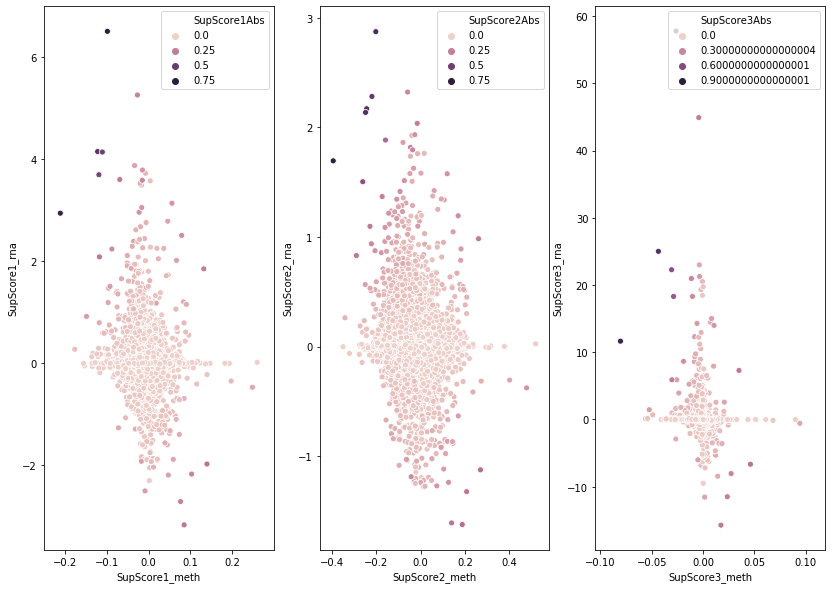

In [143]:
fig, ax = plt.subplots(ncols=3, figsize=(14,10))
agg = Merged[['Gene_RNA', 'SupScore1_meth', 'SupScore1_rna', 'SupScore1Abs']].groupby('Gene_RNA').mean().reset_index()
sns.scatterplot(data=agg, x='SupScore1_meth', y='SupScore1_rna', hue='SupScore1Abs', ax=ax[0])
agg = Merged[['Gene_RNA', 'SupScore2_meth', 'SupScore2_rna', 'SupScore2Abs']].groupby('Gene_RNA').mean().reset_index()
sns.scatterplot(data=agg, x='SupScore2_meth', y='SupScore2_rna', hue='SupScore2Abs', ax=ax[1])
agg = Merged[['Gene_RNA', 'SupScore3_meth', 'SupScore3_rna', 'SupScore3Abs']].groupby('Gene_RNA').mean().reset_index()
sns.scatterplot(data=agg, x='SupScore3_meth', y='SupScore3_rna', hue='SupScore3Abs', ax=ax[2])

In [51]:
offset = 1e-3
def Mtransform(x):
    try:
        return np.log2((x+offset)/(1-x+offset))
    except ValueError:
        return np.nan
    
def Btransform(x):
    try:
        return np.power(2, x)/(np.power(2, x)+1)
    except:
        return np.nan

In [52]:
#Merged['RNA_fc_median_Bvalue'] = Merged.fold_change_median_RNA.apply(Btransform)        
#Merged['Methylation_fc_median_Mvalue'] = Merged.abs_fc_median_Methylation.apply(Mtransform)

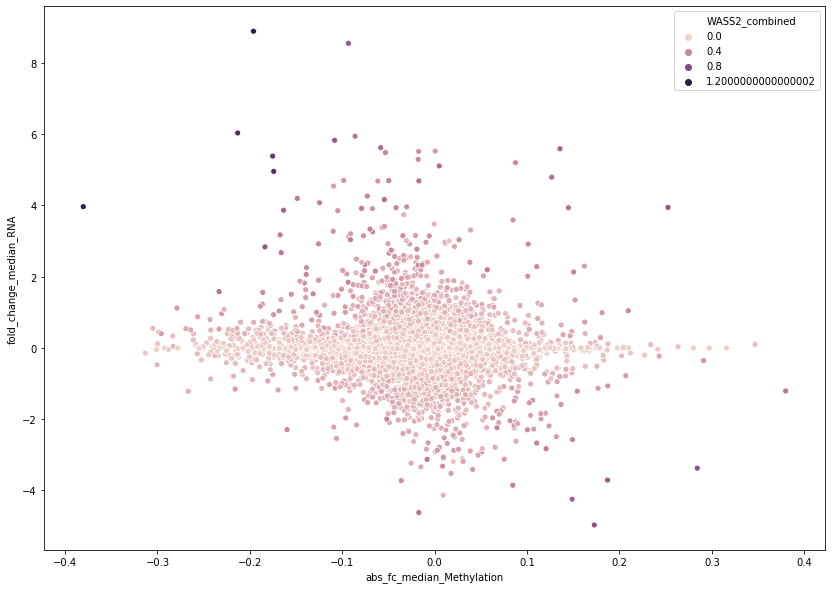

In [54]:
## Combined RNA & Methylation
fig, ax = plt.subplots(figsize=(14,10))
agg=Merged[['Gene_RNA', 'fc_split_RNA', 'fold_change_median_RNA', 'abs_fc_median_Methylation', 'RNA_fc_median_Bvalue',
            'WASS1_prod', 'WASS2_combined', 'score_FDR_RNA', 'fold_change_rel_RNA', 'Methylation_fc_median_Mvalue',
            'score_KS_RNA', 'score_KS_Methylation', 'score_WASS1_RNA', 'score_WASS1_Methylation']].groupby(by='Gene_RNA').mean()
sns.scatterplot(data=agg.query('fold_change_rel_RNA<2500').query('fold_change_rel_RNA>-100'),
                y='fold_change_median_RNA', x='abs_fc_median_Methylation', alpha=1, hue='WASS2_combined')